# Logistic Regression with Bag of Words

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

from notebooks.models.tokenizers import CustomTokenizer

In [2]:
# Load dataset.csv into a pandas dataframe
df = pd.read_csv('../data/dataset.csv', index_col=0)

# Shuffle dataset
df = df.sample(frac=1)

df.head()

,id,url,title,text,category
181135,61021589,https://en.wikipedia.org/wiki/Isaac%20%28Calvo%29,Isaac (Calvo),Isaac is a statue by Epitacio Calvo.\n\nOne co...,art
193811,66571017,https://en.wikipedia.org/wiki/Sexual%20violenc...,Sexual violence in the Tigray War,"Sexual violence in the Tigray War included, ac...",war
28460,4380270,https://en.wikipedia.org/wiki/Sonning%20Cutting,Sonning Cutting,Sonning Cutting is on the original Great Weste...,geography
138975,43125965,https://en.wikipedia.org/wiki/Nothing%20%28A%2...,Nothing (A Chorus Line song),"Nothing, also referred to as Montage Part 2, i...",music
85169,23358450,https://en.wikipedia.org/wiki/Nabeel%20Kassis,Nabeel Kassis,"Nabeel Kassis (), also transliterated as Nabil...",finance


## Bag of Words


In [3]:
size = 10_000

In [4]:
X = df['text'][:size]
y = df['category'][:size]

X.head()

181135    Isaac is a statue by Epitacio Calvo.\n\nOne co...
193811    Sexual violence in the Tigray War included, ac...
28460     Sonning Cutting is on the original Great Weste...
138975    Nothing, also referred to as Montage Part 2, i...
85169     Nabeel Kassis (), also transliterated as Nabil...
Name: text, dtype: object

In [5]:
# We use the custom tokenizer and remove stopwords
tokenizer = CustomTokenizer(remove_stopwords=True)

X_encoded = X.apply(tokenizer.encode)

X_encoded.head()

181135    [10994, 582, 35372, 67422, 36970, 1652, 3415, ...
193811    [44687, 9349, 259, 5346, 352, 4208, 5343, 11, ...
28460     [942, 1251, 14713, 4113, 2294, 19001, 40106, 5...
138975    [42312, 11, 14183, 97044, 220, 17, 11, 5609, 1...
85169     [77, 8393, 301, 597, 33567, 39204, 12215, 5158...
Name: text, dtype: object

In [6]:
# We get the vocabulary
vocab = set()

for tokens in X_encoded:
    for token in tokens:
        vocab.add(token)

vocab_size = len(vocab)
vocab_size

42550

In [7]:
# We create the bag of words

X_encoded = X_encoded.to_frame() 
X_encoded['bow'] = pd.Series(dtype='object')

def create_bow(tokens):
    bow = {}
    for token in tokens:
        if token in bow:
            bow[token] += 1
        else:
            bow[token] = 1
    return bow

X_encoded['bow'] = X_encoded['text'].apply(lambda x: create_bow(x))

X_encoded.head()

,text,bow
181135,"[10994, 582, 35372, 67422, 36970, 1652, 3415, ...","{10994: 1, 582: 1, 35372: 1, 67422: 1, 36970: ..."
193811,"[44687, 9349, 259, 5346, 352, 4208, 5343, 11, ...","{44687: 2, 9349: 17, 259: 41, 5346: 37, 352: 2..."
28460,"[942, 1251, 14713, 4113, 2294, 19001, 40106, 5...","{942: 1, 1251: 3, 14713: 6, 4113: 1, 2294: 2, ..."
138975,"[42312, 11, 14183, 97044, 220, 17, 11, 5609, 1...","{42312: 2, 11: 4, 14183: 1, 97044: 1, 220: 3, ..."
85169,"[77, 8393, 301, 597, 33567, 39204, 12215, 5158...","{77: 1, 8393: 2, 301: 2, 597: 5, 33567: 6, 392..."


## Format the data to be used in PyTorch

In [8]:
label_encoder = LabelEncoder()
classes = np.array(y.values)

integer_encoded = label_encoder.fit_transform(classes) # Transform classes to integers

integer_encoded

array([ 2, 18,  8, ...,  3,  1, 12])

In [9]:
# We first need to change the bag of words to a vector so that we can transform it to a tensor
vocab_list = list(vocab)

def bow_to_vector(bow):
    vector = np.zeros(vocab_size)
    for word, count in bow.items():
        index = vocab_list.index(word)
        vector[index] = count
    return vector

tqdm.pandas() # To use progress_apply and better visualize the progress

X_vector = X_encoded['bow'].progress_apply(bow_to_vector)

X_vector.head()

100%|██████████| 10000/10000 [06:26<00:00, 25.90it/s]


181135    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
193811    [0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 7.0, ...
28460     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
138975    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
85169     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: bow, dtype: object

In [10]:
# Convert to PyTorch tensors

X = np.array(X_vector.tolist()) # Convert to numpy array

X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(integer_encoded, dtype=torch.long)

X_tensor.shape, y_tensor.shape

(torch.Size([10000, 42550]), torch.Size([10000]))

In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader objects
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Logistic Regression Model

In [12]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(vocab_size, num_classes)
    
    def forward(self, x):
        return self.linear(x)

class MultiLayerPerceptron(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class MultiLayerPerceptron2(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron2, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim*2)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

num_epochs = 20
vocab_size = X_tensor.shape[1]
num_classes = len(set(y.values))

model = LogisticRegressionModel(vocab_size, num_classes)
#model = MultiLayerPerceptron2(vocab_size, 10, num_classes)
print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.005)
#optimizer = optim.AdamW(model.parameters(), lr=0.005)

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.float()
        labels = labels.long()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels)
            all_predictions.extend(predicted)

    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

LogisticRegressionModel(
  (linear): Linear(in_features=42550, out_features=20, bias=True)
)
Epoch [1/20], Loss: 1.4541
Precision: 0.7922, Recall: 0.7625, F1 Score: 0.7547
Epoch [2/20], Loss: 0.1641
Precision: 0.7965, Recall: 0.7810, F1 Score: 0.7822
Epoch [3/20], Loss: 0.0800
Precision: 0.7954, Recall: 0.7530, F1 Score: 0.7522
Epoch [4/20], Loss: 0.0490
Precision: 0.8039, Recall: 0.8020, F1 Score: 0.7995
Epoch [5/20], Loss: 0.0143
Precision: 0.8119, Recall: 0.8110, F1 Score: 0.8083
Epoch [6/20], Loss: 0.0091
Precision: 0.8158, Recall: 0.8155, F1 Score: 0.8126
Epoch [7/20], Loss: 0.0119
Precision: 0.8150, Recall: 0.8135, F1 Score: 0.8109
Epoch [8/20], Loss: 0.0088
Precision: 0.8141, Recall: 0.8135, F1 Score: 0.8107
Epoch [9/20], Loss: 0.0116
Precision: 0.8144, Recall: 0.8135, F1 Score: 0.8107
Epoch [10/20], Loss: 0.0055
Precision: 0.8129, Recall: 0.8125, F1 Score: 0.8098
Epoch [11/20], Loss: 0.0078
Precision: 0.8110, Recall: 0.8110, F1 Score: 0.8083
Epoch [12/20], Loss: 0.0048
Precisio

## Confusion Matrix

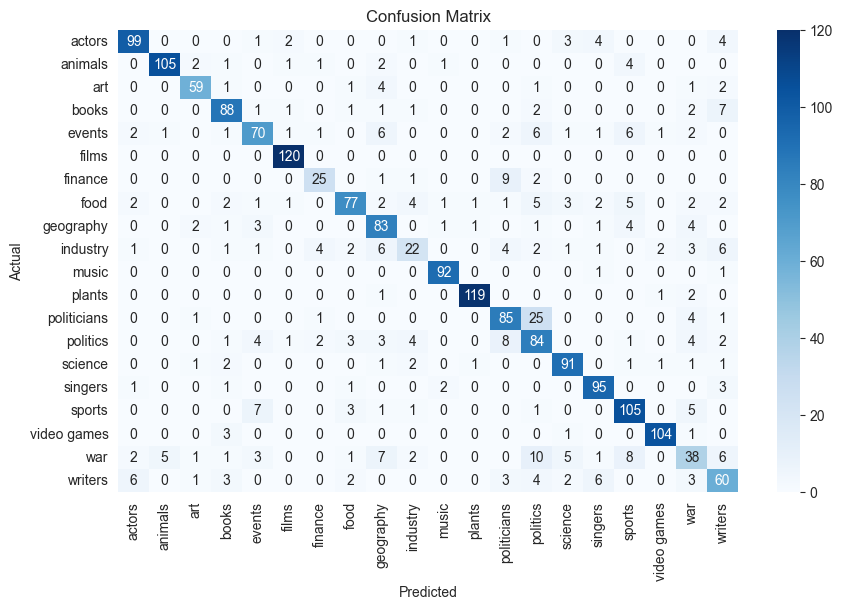

In [13]:
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels)
        all_predictions.extend(predicted)
        
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()